In [1]:
# Dependencies
# !pip install langchain unstructured[pdf] langchain_community langchain_openai chromadb tesseract
# !apt-get update && apt-get install ffmpeg libsm6 libxext6 poppler-utils tesseract-ocr python3-pil

# OpenAI API Key if using GPT-4o, otherwise can skip if using open source
# !export OPENAI_API_KEY="my-key"

# Else, install Ollama if using open source
# !curl -fsSL https://ollama.com/install.sh | sh
# !ollama pull llava:34b
# !ollama pull snowflake-arctic-embed

In [2]:
from langchain.text_splitter import CharacterTextSplitter
from unstructured.partition.pdf import partition_pdf


# Extract elements from PDF
def extract_pdf_elements(path, fname):
    """
    Extract images, tables, and chunk text from a PDF file.
    path: File path, which is used to dump images (.jpg)
    fname: File name
    """
    return partition_pdf(fname,
                       extract_images_in_pdf=True,
                       infer_table_structure=True,
                       strategy="auto",
                        max_characters=4000,
                        new_after_n_chars=3800,
                        combine_text_under_n_chars=2000
    )


# Categorize elements by type
def categorize_elements(raw_pdf_elements):
    """
    Categorize extracted elements from a PDF into tables and texts.
    raw_pdf_elements: List of unstructured.documents.elements
    """
    tables = []
    texts = []
    for element in raw_pdf_elements:
        if "unstructured.documents.elements.Table" in str(type(element)):
            tables.append(str(element))
        elif "unstructured.documents.elements.CompositeElement" in str(type(element)):
            texts.append(str(element))
        elif "unstructured.documents.elements.Title" in str(type(element)):
            texts.append(str(element))
        elif "unstructured.documents.elements.Text" in str(type(element)):
            texts.append(str(element))
        elif "unstructured.documents.elements.NarrativeText" in str(type(element)):
            texts.append(str(element))
        elif "unstructured.documents.elements.ListItem" in str(type(element)):
            texts.append(str(element))
    return texts, tables


# File path
fpath = "~/pattern/Attention_is_all_you_need.pdf"
fname = "Attention_is_all_you_need.pdf"

# Get elements
raw_pdf_elements = extract_pdf_elements(fpath, fname)

# Get text, tables
texts, tables = categorize_elements(raw_pdf_elements)

# Optional: Enforce a specific token size for texts
text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=4000, chunk_overlap=0
)
joined_texts = " ".join(texts)
texts_4k_token = text_splitter.split_text(joined_texts)

/home/nvidia/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkp

In [3]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
import os

# OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
# Generate summaries of text elements
def generate_text_summaries(texts, tables, summarize_texts=False):
    """
    Summarize text elements
    texts: List of str
    tables: List of str
    summarize_texts: Bool to summarize texts
    """

    # Prompt
    prompt_text = """You are an assistant tasked with summarizing tables and text for retrieval. \
    These summaries will be embedded and used to retrieve the raw text or table elements. \
    Give a concise summary of the table or text that is well optimized for retrieval. Table or text: {element} """
    prompt = ChatPromptTemplate.from_template(prompt_text)

    # Text summary chain
    model = ChatOpenAI(temperature=0, api_key="my-key", model="gpt-4")
    # model = ChatOpenAI(
    #     temperature=0, 
    #     base_url='http://localhost:11434/v1/',
    #     model='llava:34b',
    #     api_key="ollama",
    # )
    summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

    # Initialize empty summaries
    text_summaries = []
    table_summaries = []

    # Apply to text if texts are provided and summarization is requested
    if texts and summarize_texts:
        text_summaries = summarize_chain.batch(texts, {"max_concurrency": 5})
    elif texts:
        text_summaries = texts

    # Apply to tables if tables are provided
    if tables:
        table_summaries = summarize_chain.batch(tables, {"max_concurrency": 5})

    return text_summaries, table_summaries


# Get text, table summaries
text_summaries, table_summaries = generate_text_summaries(
    texts_4k_token, tables, summarize_texts=True
)

In [4]:
import base64
import os
from langchain_openai import ChatOpenAI

from langchain_core.messages import HumanMessage


def encode_image(image_path):
    """Getting the base64 string"""
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")


def image_summarize(img_base64, prompt):
    """Make image summary"""
    chat = ChatOpenAI(model="gpt-4o", api_key="my-key", max_tokens=200)
    # chat = ChatOpenAI(
    #     base_url='http://localhost:11434/v1/',
    #     model='llava:34b',
    #     api_key="ollama",
    #     max_tokens=400
    # )

    msg = chat.invoke(
        [
            HumanMessage(
                content=[
                    {"type": "text", "text": prompt},
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:image/jpeg;base64,{img_base64}"},
                    },
                ]
            )
        ]
    )
    return msg.content


def generate_img_summaries(path):
    """
    Generate summaries and base64 encoded strings for images
    path: Path to list of .jpg files extracted by Unstructured
    """

    # Store base64 encoded images
    img_base64_list = []

    # Store image summaries
    image_summaries = []

    # Prompt
    from tqdm import tqdm
    import time

    prompt = """You are an assistant tasked with summarizing images for retrieval. \
        These summaries will be embedded and used to retrieve the raw image. \
        Give a detailed summary of the image that is well optimized for retrieval. \
        Make sure you describe every component of the image \
        as well as and any relevant relationships those components may have with each other. """

    count = 0

    for img_file in tqdm(sorted(os.listdir(path)), desc="Processing images"):
        if img_file.endswith(".jpg"):
            img_path = os.path.join(path, img_file)

            try:
                base64_image = encode_image(img_path)
                img_base64_list.append(base64_image)
                image_summaries.append(image_summarize(base64_image, prompt))
                count += 1

            except Exception as e:
                print(f"Error processing image {img_file}: {e}")

    return img_base64_list, image_summaries


# Image summaries
img_base64_list, image_summaries = generate_img_summaries("/home/nvidia/pattern/figures")

Processing images: 100%|████████████████████████████████| 7/7 [00:49<00:00,  7.01s/it]


In [5]:
import uuid, os

from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.storage import InMemoryStore
from langchain_community.vectorstores import Chroma
from langchain_core.documents import Document
from langchain_openai import OpenAIEmbeddings
from langchain_ollama import OllamaEmbeddings

def create_multi_vector_retriever(
    vectorstore, text_summaries, texts, table_summaries, tables, image_summaries, images
):
    """
    Create retriever that indexes summaries, but returns raw images or texts
    """

    # Initialize the storage layer
    store = InMemoryStore()
    id_key = "doc_id"

    # Create the multi-vector retriever
    retriever = MultiVectorRetriever(
        vectorstore=vectorstore,
        docstore=store,
        id_key=id_key,
    )

    # Helper function to add documents to the vectorstore and docstore
    def add_documents(retriever, doc_summaries, doc_contents):
        doc_ids = [str(uuid.uuid4()) for _ in doc_contents]
        summary_docs = [
            Document(page_content=s, metadata={id_key: doc_ids[i]})
            for i, s in enumerate(doc_summaries)
        ]
        retriever.vectorstore.add_documents(summary_docs)
        retriever.docstore.mset(list(zip(doc_ids, doc_contents)))

    # Add texts, tables, and images
    # Check that text_summaries is not empty before adding
    if text_summaries:
        add_documents(retriever, text_summaries, texts)
    # Check that table_summaries is not empty before adding
    if table_summaries:
        add_documents(retriever, table_summaries, tables)
    # Check that image_summaries is not empty before adding
    if image_summaries:
        add_documents(retriever, image_summaries, images)

    return retriever

# The vectorstore to use to index the summaries
vectorstore = Chroma(
    collection_name="rag-storage", embedding_function=OllamaEmbeddings(model="snowflake-arctic-embed")
)

# Create retriever
retriever_multi_vector_img = create_multi_vector_retriever(
    vectorstore,
    text_summaries,
    texts,
    table_summaries,
    tables,
    image_summaries,
    img_base64_list,
)

/tmp/ipykernel_1426226/2742491948.py:52: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the langchain-chroma package and should be used instead. To use it run `pip install -U langchain-chroma` and import as `from langchain_chroma import Chroma`.
  vectorstore = Chroma(


In [6]:
import io
import re

from IPython.display import HTML, display
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from PIL import Image


def plt_img_base64(img_base64):
    """Disply base64 encoded string as image"""
    # Create an HTML img tag with the base64 string as the source
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'
    # Display the image by rendering the HTML
    display(HTML(image_html))


def looks_like_base64(sb):
    """Check if the string looks like base64"""
    return re.match("^[A-Za-z0-9+/]+[=]{0,2}$", sb) is not None


def is_image_data(b64data):
    """
    Check if the base64 data is an image by looking at the start of the data
    """
    image_signatures = {
        b"\xFF\xD8\xFF": "jpg",
        b"\x89\x50\x4E\x47\x0D\x0A\x1A\x0A": "png",
        b"\x47\x49\x46\x38": "gif",
        b"\x52\x49\x46\x46": "webp",
    }
    try:
        header = base64.b64decode(b64data)[:8]  # Decode and get the first 8 bytes
        for sig, format in image_signatures.items():
            if header.startswith(sig):
                return True
        return False
    except Exception:
        return False


def resize_base64_image(base64_string, size=(128, 128)):
    """
    Resize an image encoded as a Base64 string
    """
    # Decode the Base64 string
    img_data = base64.b64decode(base64_string)
    img = Image.open(io.BytesIO(img_data))

    # Resize the image
    resized_img = img.resize(size, Image.LANCZOS)

    # Save the resized image to a bytes buffer
    buffered = io.BytesIO()
    resized_img.save(buffered, format=img.format)

    # Encode the resized image to Base64
    return base64.b64encode(buffered.getvalue()).decode("utf-8")


def split_image_text_types(docs):
    """
    Split base64-encoded images and texts
    """
    b64_images = []
    texts = []
    for doc in docs:
        # Check if the document is of type Document and extract page_content if so
        if isinstance(doc, Document):
            doc = doc.page_content
        if looks_like_base64(doc) and is_image_data(doc):
            doc = resize_base64_image(doc, size=(1300, 600))
            b64_images.append(doc)
        else:
            texts.append(doc)
    return {"images": b64_images, "texts": texts}


def img_prompt_func(data_dict):
    """
    Join the context into a single string
    """
    formatted_texts = "\n".join(data_dict["context"]["texts"])
    messages = []

    # Adding image(s) to the messages if present
    if data_dict["context"]["images"]:
        for image in data_dict["context"]["images"]:
            image_message = {
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{image}"},
            }
            messages.append(image_message)

    # Adding the text for analysis
    text_message = {
        "type": "text",
        "text": (
            "You are a deep learning and machine learning specialist.\n"
            "You may be given a mixed of text, tables, and images.\n"
            "Use this information to provide quality information related to the user question. \n"
            f"User-provided question: {data_dict['question']}\n\n"
            "Text and / or tables:\n"
            f"{formatted_texts}"
        ),
    }
    messages.append(text_message)
    return [HumanMessage(content=messages)]


def multi_modal_rag_chain(retriever):
    """
    Multi-modal RAG chain
    """

    # Multi-modal LLM
    model = ChatOpenAI(temperature=0, model="gpt-4o", api_key="my-key", max_tokens=1024)
    # model = ChatOpenAI(
    #     temperature=0, 
    #     base_url='http://localhost:11434/v1/',
    #     model='llava:34b',
    #     api_key="ollama",
    #     max_tokens=1024
    # )

    # RAG pipeline
    chain = (
        {
            "context": retriever | RunnableLambda(split_image_text_types),
            "question": RunnablePassthrough(),
        }
        | RunnableLambda(img_prompt_func)
        | model
        | StrOutputParser()
    )

    return chain


# Create RAG chain
chain_multimodal_rag = multi_modal_rag_chain(retriever_multi_vector_img)

In [7]:
# Check retrieval

##### Test for Images in the doc #####
##### What color is the softmax layer in the transformer model architecture diagram? #####
##### What color is the input embedding layer in the transformer model architecture diagram? #####
##### What layer comes after the optional Mask layer in the scaled dot-product attention block? #####

query = "What color is the softmax layer in the transformer model architecture diagram?"
docs = retriever_multi_vector_img.get_relevant_documents(query, limit=6)

len(docs)

/tmp/ipykernel_1426226/3712361279.py:9: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use invoke instead.
  docs = retriever_multi_vector_img.get_relevant_documents(query, limit=6)


4

In [8]:
# Run RAG chain
response = chain_multimodal_rag.invoke(query)
response = response.split('.')

# Print each line in a new line
for line in response:
    print(line)

In the transformer model architecture diagram, the softmax layer is colored in light green



Here is the transformer model diagram in the Attention is All You Need research paper, for reference. 

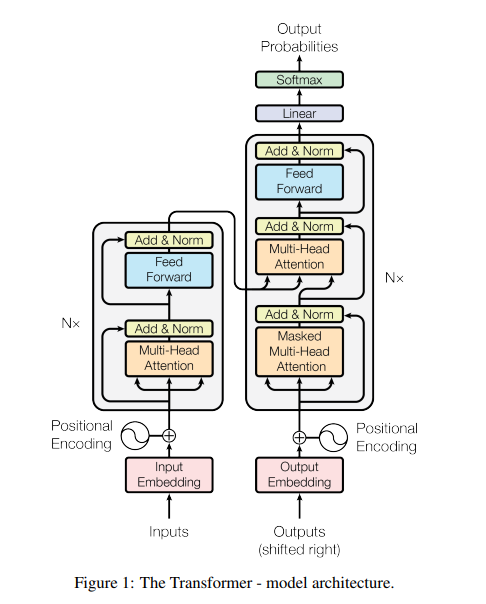

In [9]:
##### Test for Tables in the doc #####
##### What is the BLEU score for ByteNet model? #####
##### What is the BLEU score for ConvS2S model? #####
##### What is the complexity of the Maximum Path Lengths for a convolutional layer type? #####

query = "What is the BLEU score for ByteNet model?"
docs = retriever_multi_vector_img.get_relevant_documents(query, limit=6)

len(docs)

4

In [10]:
# Run RAG chain
response = chain_multimodal_rag.invoke(query)

print(response)

The BLEU score for the ByteNet model for the EN-DE (English to German) translation task is 23.75. 

This information is extracted from the provided table, which lists various models and their BLEU scores for different translation tasks. The ByteNet model's BLEU score for EN-DE is specifically mentioned as 23.75.


In [11]:
##### Test for Text in the doc #####
##### How many days did the 'big' transformer model take to train and on what type of hardware? #####

query = "How many days did the 'big' transformer model take to train and on what type of hardware?"
docs = retriever_multi_vector_img.get_relevant_documents(query, limit=6)

len(docs)

4

In [12]:
# Run RAG chain
response = chain_multimodal_rag.invoke(query)

print(response)

The 'big' transformer model, as described in the provided data, took approximately 3.5 days to train. This training was conducted on 8 NVIDIA P100 GPUs. 

The 'big' transformer model achieved a BLEU score of 28.4 for English-to-German (EN-DE) and 41.8 for English-to-French (EN-FR) translations. The training cost in terms of FLOPs (Floating Point Operations) was 2.3 × 10^19.
